# Introduction & Preparation 

## Introduction

The goal of this notebook is to showcase the so-called 'Inverse Optimization' algorithm on some synthetic datasets. The goal of this algorithm is to generate some new dataset that has the same (persistent) topological characteristics as some target dataset that we input. For this we use the persistent diagrams of some input and target dataset as a loss.

## Preparation

In this notebook we make use of different packages. One of the packages that we make use of is `inverse_optim` which include functions tailor made for this notebook. We want to make sure that any changes in `inverse_optim` are directly reflected in this notebook. For this we use the first three lines of code, after which we include the packages as usual. If you run into problems with `inverse_optim`, please read the README.md file on the repository.

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import sancho
import tadasets
import gudhi as gd
import powerbox as pbox

Modules to reload:
all-except-skipped

Modules to skip:



2023-05-22 23:20:15.800599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Circle and the Figure Eight

First, choose which figure you would like to generate. You can comment out the figure you are not interested in.

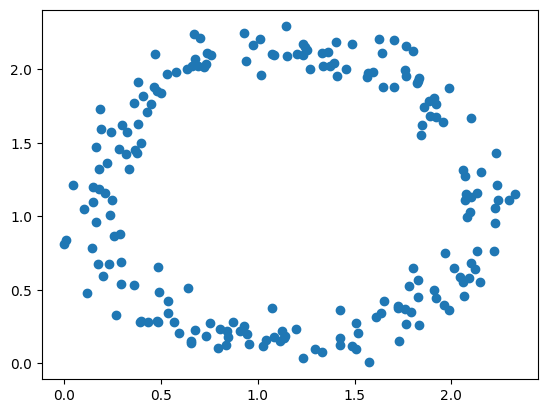

In [4]:
# This is a synthetic data set that we want "approximate"
N = 200
goal_pts = tadasets.dsphere(n=N, d=1, noise=0.1) # circle
# goal_pts = tadasets.infty_sign(n=N, noise=0.1) # figure eight

# Translate whole point set so that nothing is negative
min_coord = np.min(goal_pts)
goal_pts = goal_pts - min_coord

# Find box_size
box_size = np.max(goal_pts)

# To perform Stochastic Gradient Descent (SGD), we need our set to be of tensor type
goal_pts = torch.tensor(goal_pts)

# Plot the initial/goal data set
P = goal_pts.detach().numpy()
plt.scatter(P[:, 0], P[:, 1])
plt.show()

Below you will find multiple methods with which you can use the algorithm. The current methods include: Ripser filtration, Alpha-DTM (Hybrid) Filtration and Alpha-Ripser Hybrid Filtration.

## Ripser Filtration

### Creation of dataset

For optimization purposes, we are interested in the pairwise distances of all the points. 

In the Rips filtration, we are constantly looking at sub-complexes of the largest possible complex given a dataset. The interesting parts of the filtration (that capture the persistent features) happen at a stage that is in the beginning before the total complex is reached. So if we are interested in optimizing the filtration, we could put a threshold on the possible edge lengths that are drawn without losing (too much) information.

To that end we will look at the pairwise distances of all points in the initial/goal point cloud and then determine what the 60-90th percentile is. It could be argued that for higher dimensional PD's, the persistence happens at later stages in general, meaning you would need a higher percentile. 

A guideline that is currently used (based on clinical estimations of a few trials and input of other postdocs/phds who are working with this project):
- Zero dimensional PD: 70
- One dimensional PD: 80
- Two dimensional PD: 90



In [3]:
from scipy.spatial.distance import cdist

# Initialize percentile
percentile = 80

# Creation of list of all pairwise distances
goal_D = cdist(goal_pts, goal_pts)
distance_vec = goal_D.flatten()

# Define maximum edge length
max_edge_length = np.percentile(distance_vec, percentile)

In [17]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_rips_pd(pts=goal_pts, max_edge_length=max_edge_length)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric. Warning: This is extremely slow compared to the other filtrations.

In [ ]:
lr_list = np.linspace(0.001, 1, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="rips", max_edge_length=max_edge_length, box_size=box_size)

After running the above code, plug in the best learning rate:

In [ ]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.08, epochs=600, decay_speed=30, investigate=False, sliced=False, filtr="rips", box_size=box_size)

### The powerspectrum

Later on we will focus on so-called Gaussian Random Fields (GRF). A characteristic feature of GRF's is their power spectrum. For that reason, we will already test whether the generated data set and the target dataset have the same power spectrum.

In [ ]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Alpha DTM Filtration

### Creation of dataset

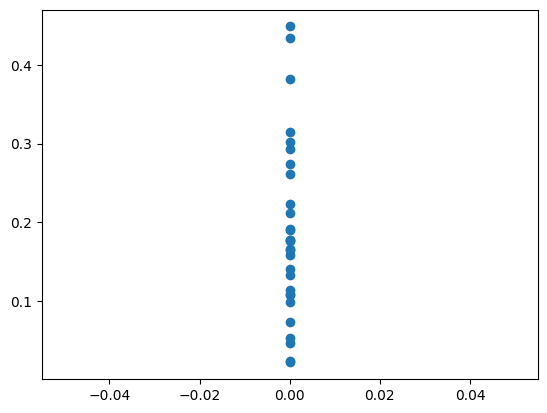

In [38]:
# Creation of the PD that we want to get to
# goal_pd = gen_data.create_hybrid_dtm_pd(goal_pts)
goal_pd = gen_data.create_line_pd(goal_pts)

plt.scatter(goal_pd[0][:,0], goal_pd[0][:,1])

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

Note: It seems like setting `m=0.7` and `p=1.5` give a circle without any stray points inside the circle. If you would like to change these values, they are unfortunately still hardcoded in the `gen_data.py` file. Go to the function `create_hybrid_dtm_pd` and change the values there. Support for changing these values in this notebook will come soon.

100%|██████████| 300/300 [00:13<00:00, 22.55it/s]


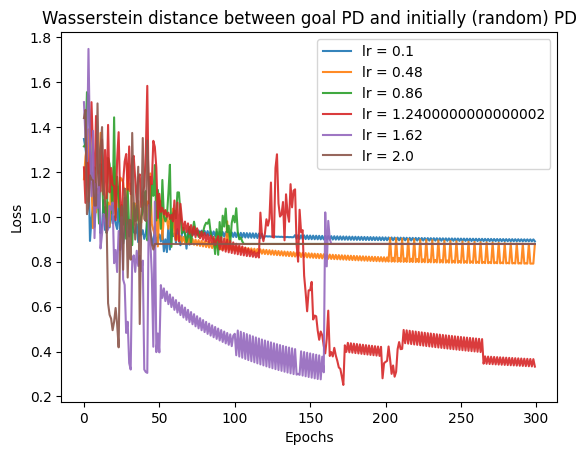

In [24]:
lr_list = np.linspace(0.1, 2, 6)
# research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="alpha_dtm", box_size=box_size)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="line", box_size=box_size)

After running the above code, plug in the best learning rate:

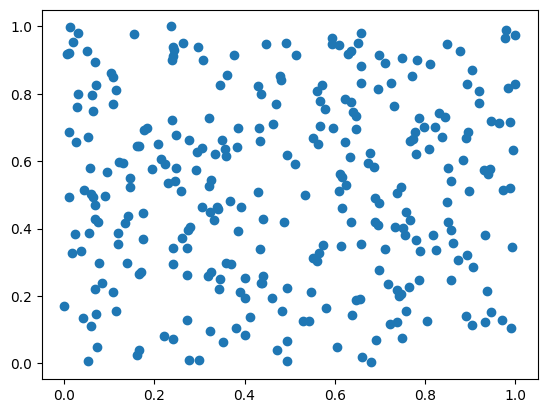

  1%|          | 4/600 [00:00<00:17, 33.87it/s]

0: 0.9524706075485302
1: 1.0565606072138567
0: 0.8490677365287882
1: 1.1147036268900652
0: 0.9952727519524867
1: 0.9910853666108962
0: 0.8674838228231474
1: 0.9068667191233326
0: 0.9565256888151012
1: 0.8367019831727762
0: 0.9206762507898893
1: 1.0144040301035662
0: 0.805960257268832
1: 0.9702732053924059


  2%|▏         | 12/600 [00:00<00:17, 33.18it/s]

0: 0.8240279875489745
1: 1.0341402306746263
0: 0.9079308808772728
1: 1.0692359074543734
0: 0.5678494089618493
1: 1.0745026549807708
0: 0.8222129505696021
1: 1.1112384600320748
0: 0.7729103489869427
1: 0.9733847692202349
0: 0.4290998729509345
1: 0.9927365868877192
0: 0.4573131037535094
1: 1.1348812515999962


  3%|▎         | 20/600 [00:00<00:18, 30.61it/s]

0: 0.5794990449596298
1: 0.9160470372549215
0: 0.6790142358107423
1: 1.1111429296266304
0: 0.8361816886584204
1: 0.8929090696311245
0: 0.7524614867627228
1: 1.1239843768754891
0: 0.6340535549785355
1: 0.9953775070440041
0: 0.7044072772613077
1: 0.9378553902137732


  4%|▍         | 24/600 [00:00<00:20, 28.10it/s]

0: 0.6782952994758451
1: 1.0647287528183151
0: 0.6358925213798378
1: 0.9085931566882586
0: 0.6566751503013519
1: 0.976507374603631
0: 0.6650295632645509
1: 0.9317314453016539
0: 0.8196300512368582
1: 0.9026869620349098


  5%|▌         | 30/600 [00:01<00:20, 27.19it/s]

0: 0.7323479796569982
1: 0.9908216606046845
0: 0.6498446401901806
1: 1.0086901498365854
0: 0.6057617272861957
1: 1.0156540883112406
0: 0.5192675209844817
1: 1.0074931271206604
0: 0.5278064693962768
1: 1.1466332090425944
0: 0.5603978455229489
1: 0.8798260949384438


  6%|▌         | 36/600 [00:01<00:20, 27.67it/s]

0: 0.5420996877516124
1: 0.9000548077503137
0: 0.5472343782335338
1: 1.1278646898794626
0: 0.48224797613813886
1: 1.0890626919794535
0: 0.5649215248391537
1: 1.020392717175529
0: 0.52329252820271
1: 0.8805375556130958
0: 0.5851273505024615
1: 1.1269212029706703
0: 0.6399510449721149
1: 0.9132185143757319


  7%|▋         | 43/600 [00:01<00:18, 29.78it/s]

0: 0.7112802004707739
1: 0.9369238995685066
0: 0.6767769957207904
1: 0.9238131058741068
0: 0.5912478951816531
1: 0.9486295742321467
0: 0.6009026570847867
1: 0.9881024820137476
0: 0.6009026570847867
1: 0.9490389687347864
0: 0.6630192177060436
1: 0.8962483567524409
0: 0.645907296116715
1: 0.879274369530723


  8%|▊         | 49/600 [00:01<00:19, 28.76it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 10%|▉         | 57/600 [00:01<00:17, 31.25it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 11%|█         | 65/600 [00:02<00:16, 31.93it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 12%|█▏        | 69/600 [00:02<00:17, 30.38it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 13%|█▎        | 77/600 [00:02<00:16, 31.03it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 14%|█▍        | 86/600 [00:02<00:14, 35.26it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 16%|█▌        | 94/600 [00:02<00:14, 35.88it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 16%|█▋        | 98/600 [00:03<00:13, 36.39it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


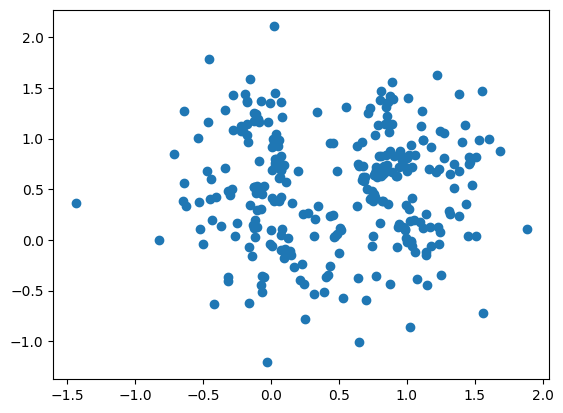

 18%|█▊        | 106/600 [00:03<00:17, 28.98it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 19%|█▉        | 114/600 [00:03<00:15, 31.36it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 20%|██        | 123/600 [00:03<00:13, 34.52it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 21%|██        | 127/600 [00:04<00:13, 35.41it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 22%|██▎       | 135/600 [00:04<00:14, 32.82it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 24%|██▍       | 144/600 [00:04<00:12, 35.20it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 25%|██▌       | 152/600 [00:04<00:12, 35.79it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 27%|██▋       | 160/600 [00:04<00:12, 33.91it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 27%|██▋       | 164/600 [00:05<00:12, 33.63it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 29%|██▊       | 172/600 [00:05<00:12, 33.12it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 30%|███       | 180/600 [00:05<00:12, 33.64it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 31%|███       | 184/600 [00:05<00:12, 34.31it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 32%|███▏      | 192/600 [00:05<00:13, 31.37it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 33%|███▎      | 197/600 [00:06<00:11, 34.40it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


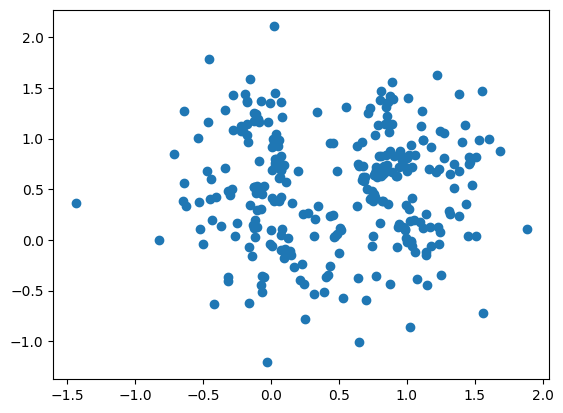

 34%|███▍      | 205/600 [00:06<00:14, 27.99it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 36%|███▌      | 214/600 [00:06<00:12, 32.05it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 36%|███▋      | 218/600 [00:06<00:11, 31.84it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 38%|███▊      | 226/600 [00:07<00:12, 30.01it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 38%|███▊      | 230/600 [00:07<00:12, 29.84it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 40%|███▉      | 238/600 [00:07<00:13, 26.76it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 41%|████      | 246/600 [00:07<00:11, 30.34it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 42%|████▏     | 254/600 [00:08<00:10, 33.22it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 43%|████▎     | 258/600 [00:08<00:10, 34.00it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 44%|████▍     | 266/600 [00:08<00:10, 32.44it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 46%|████▌     | 274/600 [00:08<00:09, 34.27it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 47%|████▋     | 283/600 [00:08<00:09, 34.32it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 48%|████▊     | 287/600 [00:09<00:09, 31.79it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 49%|████▉     | 295/600 [00:09<00:10, 29.70it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 50%|████▉     | 299/600 [00:09<00:09, 31.53it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


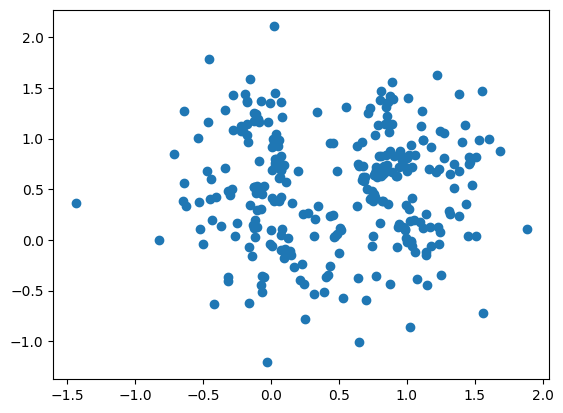

 51%|█████     | 307/600 [00:09<00:10, 27.24it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 52%|█████▎    | 315/600 [00:09<00:09, 31.35it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 54%|█████▍    | 323/600 [00:10<00:08, 33.74it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 55%|█████▌    | 331/600 [00:10<00:08, 32.86it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 56%|█████▌    | 335/600 [00:10<00:08, 29.50it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 57%|█████▋    | 343/600 [00:10<00:07, 32.53it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 58%|█████▊    | 351/600 [00:11<00:08, 31.08it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 59%|█████▉    | 355/600 [00:11<00:07, 30.85it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 60%|██████    | 363/600 [00:11<00:07, 30.99it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 62%|██████▏   | 371/600 [00:11<00:06, 33.43it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 63%|██████▎   | 379/600 [00:11<00:06, 33.35it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 64%|██████▍   | 383/600 [00:12<00:06, 31.11it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 65%|██████▌   | 391/600 [00:12<00:06, 32.37it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 66%|██████▋   | 399/600 [00:12<00:06, 31.17it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


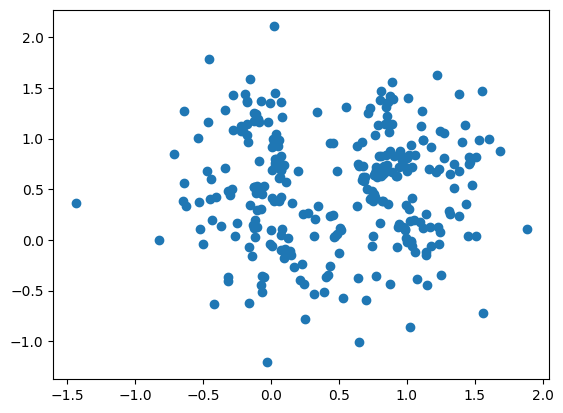

 68%|██████▊   | 406/600 [00:13<00:08, 23.47it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 69%|██████▉   | 413/600 [00:13<00:07, 26.32it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 70%|██████▉   | 419/600 [00:13<00:06, 27.65it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 71%|███████   | 425/600 [00:13<00:06, 27.45it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 71%|███████▏  | 428/600 [00:13<00:06, 27.81it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 72%|███████▏  | 434/600 [00:14<00:06, 26.28it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 74%|███████▎  | 441/600 [00:14<00:05, 28.14it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 75%|███████▍  | 449/600 [00:14<00:04, 31.37it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 76%|███████▌  | 457/600 [00:14<00:04, 31.38it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 78%|███████▊  | 465/600 [00:14<00:04, 33.11it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 79%|███████▉  | 473/600 [00:15<00:03, 34.54it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 80%|████████  | 481/600 [00:15<00:03, 33.86it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 81%|████████  | 485/600 [00:15<00:03, 32.92it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 82%|████████▏ | 493/600 [00:15<00:03, 33.93it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 83%|████████▎ | 497/600 [00:15<00:03, 30.76it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


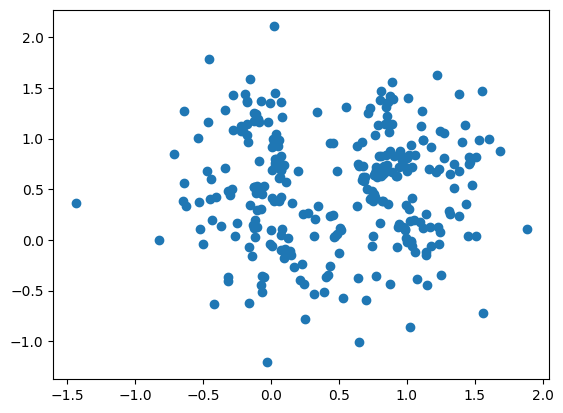

0: 0.645907296116715
1: 0.879274369530723


 84%|████████▍ | 504/600 [00:16<00:04, 22.12it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 85%|████████▍ | 508/600 [00:16<00:03, 24.43it/s]

0: 0.645907296116715
1: 0.879274369530723


 85%|████████▌ | 512/600 [00:16<00:03, 26.35it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 87%|████████▋ | 520/600 [00:16<00:02, 28.93it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 88%|████████▊ | 528/600 [00:17<00:02, 30.74it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 89%|████████▊ | 532/600 [00:17<00:02, 32.09it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 90%|█████████ | 540/600 [00:17<00:02, 28.46it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 91%|█████████ | 547/600 [00:17<00:01, 29.44it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 92%|█████████▏| 551/600 [00:17<00:01, 29.55it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 93%|█████████▎| 558/600 [00:18<00:01, 30.53it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 94%|█████████▍| 566/600 [00:18<00:01, 33.51it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 96%|█████████▌| 574/600 [00:18<00:00, 33.44it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 97%|█████████▋| 582/600 [00:18<00:00, 32.74it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 98%|█████████▊| 590/600 [00:19<00:00, 33.62it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


 99%|█████████▉| 594/600 [00:19<00:00, 32.35it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


100%|█████████▉| 598/600 [00:19<00:00, 29.47it/s]

0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723
0: 0.645907296116715
1: 0.879274369530723


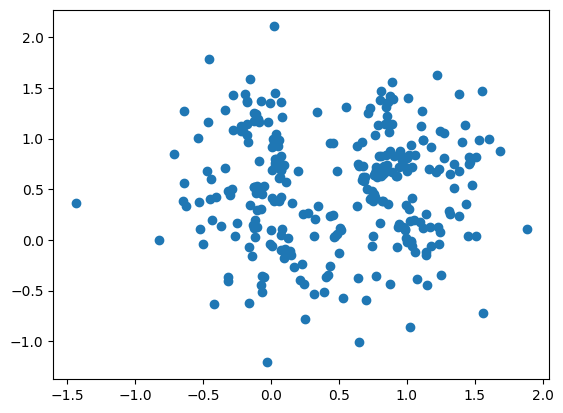

100%|██████████| 600/600 [00:19<00:00, 30.64it/s]


In [32]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=1.2, epochs=600, decay_speed=30, investigate=False, sliced=False, filtr="line")

### The powerspectrum

Later on we will focus on so-called Gaussian Random Fields (GRF). A characteristic feature of GRF's is their power spectrum. For that reason, we will already test whether the generated data set and the target dataset have the same power spectrum.

In [1]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

NameError: name 'goal_pts' is not defined

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## Alpha-Ripser Hybrid Filtration

### Creation of the new dataset

In [5]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_pd(goal_pts)

First, we need to find out what optimal learning rate is. If you would like to make the computation quicker (which will make it less accurate), pass the option sliced=True to use the sliced wasserstein distance as the metric.

100%|██████████| 300/300 [00:08<00:00, 35.57it/s]


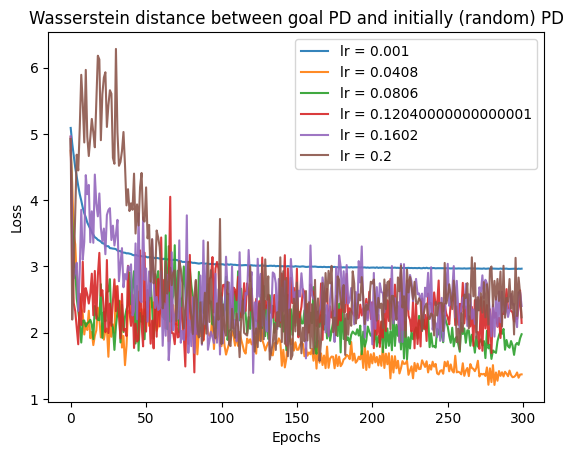

In [8]:
lr_list = np.linspace(0.001, 0.2, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=N, dim=2, epochs=300, decay_speed=30, sliced=False, filtr="alpha_rips_hybrid")

After running the above code, plug in the best learning rate:

In [9]:
# Generation of new dataset
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=N, dim=2, lr=0.04, epochs=600, decay_speed=30, investigate=False, sliced=False, filtr="alpha_rips_hybrid")

100%|██████████| 600/600 [00:08<00:00, 67.59it/s]


### The powerspectrum

In [ ]:
original_pts = goal_pts.detach().numpy()
produced_pts = final_pts.detach().numpy()

In [ ]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(original_pts, 2.0, N=N)
p_k_samples_new, bins_samples_new = pbox.get_power(produced_pts, 8.0, N=N)

In [ ]:
plt.plot(bins_samples, p_k_samples,label="Original Circle Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Circle Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')